In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import interp

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, label_binarize, LabelBinarizer
from sklearn.metrics import r2_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import catboost as cb
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

Корректируем датасет:  
1) корректировка используемого в модели значения капитализации и разницы логарифмов между раундами  
2) исключение раундов "без ответа"  
3) приведение дат к нужному формату

In [2]:
nan = [np.nan]
default_exit_value = 1 #"капитализация" мертвой компании в долларах

In [3]:
#wave_2
dataset = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/model_ver_based_on_2019/wave_2/1_DataPreparation/funding_rounds_with_exits.csv')
DEMO_SET = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/model_ver_based_on_2019/wave_2/1_DataPreparation/DEMO_SET.csv')
DEMO_SET2 = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/model_ver_based_on_2019/wave_2/1_DataPreparation/DEMO_SET2.csv')
DEMO_SET_ALL = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/model_ver_based_on_2019/wave_2/1_DataPreparation/DEMO_SET_ALL.csv')

nasd = pd.read_csv('NASDAQ_1990_2021.csv', sep=';')
#nasd['DateLong'] = pd.to_datetime(nasd['DateLong'])
nasd

,DateUnix,DateLong,Close,Deflator
0,32874,1990-01-01,454.799988,16.958994
1,32875,1990-01-02,459.299988,16.792838
2,32876,1990-01-03,460.899994,16.734542
3,32877,1990-01-04,459.399994,16.789182
4,32878,1990-01-05,458.200012,16.833151
...,...,...,...,...
10394,43268,2018-06-17,2781.909912,0.995684
10395,43269,2018-06-18,2781.909912,0.995601
10396,43270,2018-06-19,2781.909912,0.998364
10397,43271,2018-06-20,2781.909912,0.991189


In [4]:
nasd['Deflator_1M'] = nasd['Deflator'].shift(30)
nasd.loc[nasd['Deflator_1M'].isin([np.nan]), 'Deflator_1M'] = nasd['Deflator']
nasd['Deflator_3M'] = nasd['Deflator'].shift(90)
nasd.loc[nasd['Deflator_1M'].isin([np.nan]), 'Deflator_3M'] = nasd['Deflator']
nasd['Deflator_6M'] = nasd['Deflator'].shift(180)
nasd.loc[nasd['Deflator_1M'].isin([np.nan]), 'Deflator_6M'] = nasd['Deflator']
nasd['Deflator_9M'] = nasd['Deflator'].shift(270)
nasd.loc[nasd['Deflator_1M'].isin([np.nan]), 'Deflator_9M'] = nasd['Deflator']
nasd

,DateUnix,DateLong,Close,Deflator,Deflator_1M,Deflator_3M,Deflator_6M,Deflator_9M
0,32874,1990-01-01,454.799988,16.958994,16.958994,NaN,NaN,NaN
1,32875,1990-01-02,459.299988,16.792838,16.792838,NaN,NaN,NaN
2,32876,1990-01-03,460.899994,16.734542,16.734542,NaN,NaN,NaN
3,32877,1990-01-04,459.399994,16.789182,16.789182,NaN,NaN,NaN
4,32878,1990-01-05,458.200012,16.833151,16.833151,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
10394,43268,2018-06-17,2781.909912,0.995684,1.048762,1.050204,1.107570,1.194687
10395,43269,2018-06-18,2781.909912,0.995601,1.048762,1.047343,1.108030,1.200891
10396,43270,2018-06-19,2781.909912,0.998364,1.048762,1.050054,1.107330,1.200101
10397,43271,2018-06-20,2781.909912,0.991189,1.043131,1.076224,1.108189,1.200101


In [5]:
dataset = dataset.merge(nasd[['DateLong', 'Deflator', 'Deflator_1M', 'Deflator_3M', 'Deflator_6M', 'Deflator_9M']], how = 'left', left_on = 'announced_on', right_on = 'DateLong')
dataset

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,category_tag,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,DateLong,Deflator,Deflator_1M,Deflator_3M,Deflator_6M,Deflator_9M
0,778db45f-e9d1-3f73-86f4-ae4cc79c48ff,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,seed,2010-01-01,500000.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2010-01-01,3.399048,3.529906,3.765886,4.293273,4.800462
1,fc2c2560-8bb0-90d1-b048-ee9cfc3f301d,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_a,2010-11-10,3000000.0,NaN,NaN,NaN,NaN,NaN,313.0,313.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2010-11-10,2.990930,3.210612,3.521461,3.286512,3.532331
2,d863a1b9-dda0-284e-3258-fa43a20d305c,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_b,2011-05-02,10000000.0,NaN,NaN,NaN,NaN,NaN,486.0,173.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-05-02,2.692994,2.764895,2.803496,3.036272,3.363606
3,4c9cb685-ec9a-92ed-64c0-062040d9573e,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_unknown,2011-08-24,1000000.0,NaN,NaN,NaN,NaN,NaN,600.0,114.0,1.0,0.0,1.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-08-24,3.125575,2.713153,2.771531,2.773395,3.043112
4,1006ef75-d2f2-bac4-5737-dae2075cf616,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_c,2011-11-04,30000000.0,NaN,NaN,NaN,NaN,NaN,672.0,72.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-11-04,2.871377,3.134696,3.045696,2.727776,2.770466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7562,2067db69-a274-7914-0207-5fb1af6cc7ca,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_c,2012-10-23,46000000.0,NaN,2014-06-19,ipo,300000000.0,112000000.0,679.0,673.0,2.0,1.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0,2012-10-23,2.579185,2.425487,2.702278,2.528330,2.738439
7563,602347ee-2d81-7ad3-7f85-d68ea1fb8967,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_d,2014-03-05,55000000.0,NaN,2014-06-19,ipo,300000000.0,112000000.0,1177.0,498.0,2.0,1.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0,2014-03-05,1.769849,1.929704,1.912379,2.107358,2.223252
7564,-,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,ipo,2014-06-19,112000000.0,300000000.0,2014-06-19,ipo,300000000.0,112000000.0,1283.0,106.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2014-06-19,1.769297,1.882635,1.803444,1.879035,2.043312
7565,7792bf54-78d8-7159-329b-41e71e1c8f6b,Powermat Technologies,fff473e3-0f7d-b475-1da2-c9496721f49f,series_c,2011-10-06,80000000.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0,2011-10-06,3.076787,3.117817,2.697015,2.774023,2.853298


In [5]:
DEMO_SET = DEMO_SET.merge(nasd[['DateLong', 'Deflator']], how = 'left', left_on = 'announced_on', right_on = 'DateLong')
DEMO_SET

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,DateLong,Deflator
0,0ddb5b94-0c36-6a61-3194-00490c89804a,Airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,seed,2009-01-01,20000.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,1.0,17.0,26.0,29.0,29.0,9.0,10.0,2009-01-01,4.890807
1,ba7b61b6-33ca-1b0d-7d91-2fed65efc5ec,Airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,seed,2009-04-01,600000.0,NaN,NaN,NaN,NaN,NaN,90.0,90.0,1.0,1.0,17.0,26.0,29.0,29.0,9.0,10.0,2009-04-01,4.970966
2,e5e53009-a100-e579-0c07-4f44416c959a,Airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,series_a,2010-11-10,7200000.0,NaN,NaN,NaN,NaN,NaN,678.0,588.0,1.0,1.0,17.0,26.0,29.0,29.0,9.0,10.0,2010-11-10,2.990930
3,d2e9a4b6-3710-e2ea-a5c1-0ec849bde45f,Airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,series_b,2011-07-25,112000000.0,1.312000e+09,NaN,NaN,NaN,NaN,935.0,257.0,1.0,1.0,17.0,26.0,29.0,29.0,9.0,10.0,2011-07-25,2.713153
4,fb9e4d00-991e-5bb8-4d0e-2406239b50f9,Airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,series_c,2013-10-28,200000000.0,2.500000e+09,NaN,NaN,NaN,NaN,1761.0,826.0,1.0,1.0,17.0,26.0,29.0,29.0,9.0,10.0,2013-10-28,1.957537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,9bed1cb1-d7fe-62b4-c2ed-c86390443ab6,Unity Technologies,8bb8f294-4617-2031-5d2e-8ca53ffb71dd,series_b,2011-07-20,15000000.0,NaN,NaN,NaN,NaN,NaN,632.0,632.0,1.0,1.0,3.0,9.0,7.0,13.0,5.0,6.0,2011-07-20,2.740696
61,ec316956-f985-9753-56ad-0e1a9d755ed1,Unity Technologies,8bb8f294-4617-2031-5d2e-8ca53ffb71dd,series_unknown,2015-09-24,25000000.0,NaN,NaN,NaN,NaN,NaN,2159.0,1527.0,1.0,1.0,3.0,9.0,7.0,13.0,5.0,6.0,2015-09-24,1.629102
62,de331f48-481c-6bb2-a1b3-ef438475040d,Unity Technologies,8bb8f294-4617-2031-5d2e-8ca53ffb71dd,series_unknown,2015-12-09,62696700.0,NaN,NaN,NaN,NaN,NaN,2235.0,76.0,1.0,1.0,3.0,9.0,7.0,13.0,5.0,6.0,2015-12-09,1.535566
63,4a87f25b-480c-d60f-d74b-5d2988f1ca46,Unity Technologies,8bb8f294-4617-2031-5d2e-8ca53ffb71dd,series_c,2016-07-13,181000000.0,1.500000e+09,NaN,NaN,NaN,NaN,2452.0,217.0,1.0,1.0,3.0,9.0,7.0,13.0,5.0,6.0,2016-07-13,1.540824


In [6]:
DEMO_SET2 = DEMO_SET2.merge(nasd[['DateLong', 'Deflator']], how = 'left', left_on = 'announced_on', right_on = 'DateLong')
DEMO_SET2

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_2009,time_from_start,time_from_previous,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,DateLong,Deflator
0,4cb76778-cc8c-f4dd-18bf-3d06780a495c,VertiFlex,058a5313-ec27-d591-e912-2931b98e99ed,series_a,2005-07-07,6330000.0,NaN,NaN,NaN,NaN,NaN,-1274.0,0.0,NaN,1.0,1.0,4.0,3.0,12.0,6.0,5.0,5.0,2005-07-07,3.715903
1,c1920c7e-4a62-3275-a1a7-7387c6348a99,VertiFlex,058a5313-ec27-d591-e912-2931b98e99ed,series_b,2007-01-22,20000000.0,NaN,NaN,NaN,NaN,NaN,-710.0,564.0,564.0,1.0,1.0,4.0,3.0,12.0,6.0,5.0,5.0,2007-01-22,3.172656
2,04c77602-7878-8e0c-3e8a-5598a82ac0e9,VertiFlex,058a5313-ec27-d591-e912-2931b98e99ed,series_c,2008-06-25,28280000.0,NaN,NaN,NaN,NaN,NaN,-190.0,1084.0,520.0,1.0,1.0,4.0,3.0,12.0,6.0,5.0,5.0,2008-06-25,3.212043
3,cf92817c-9369-d8c4-a836-5ffc239de485,VertiFlex,058a5313-ec27-d591-e912-2931b98e99ed,series_unknown,2009-07-30,8000000.0,NaN,NaN,NaN,NaN,NaN,210.0,1484.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,2009-07-30,3.886988
4,9e838a61-e07a-1d2b-6b2a-77ebc739914a,VertiFlex,058a5313-ec27-d591-e912-2931b98e99ed,series_unknown,2010-07-02,2000000.0,NaN,NaN,NaN,NaN,NaN,547.0,1821.0,337.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,2010-07-02,3.687249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,4c9555f0-45d6-f525-a8f4-b41a51896ec1,Airware,e928b9b4-eabd-29df-1182-1c5d86b45286,series_unknown,2015-04-16,NaN,NaN,NaN,NaN,NaN,NaN,2296.0,1080.0,149.0,1.0,0.0,8.0,12.0,18.0,16.0,6.0,6.0,2015-04-16,1.540190
162,7664eaf3-c095-5068-843f-88ca44702351,Airware,e928b9b4-eabd-29df-1182-1c5d86b45286,series_c,2016-03-31,30000000.0,NaN,NaN,NaN,NaN,NaN,2646.0,1430.0,350.0,1.0,1.0,8.0,12.0,18.0,16.0,6.0,6.0,2016-03-31,1.583817
163,92b108f5-58f8-aef3-cfd9-fa8d67381002,Airware,e928b9b4-eabd-29df-1182-1c5d86b45286,series_unknown,2016-05-26,39130000.0,NaN,NaN,NaN,NaN,NaN,2702.0,1486.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,2016-05-26,1.573503
164,ca02dceb-dd40-4bca-8420-4ad506d4b1d6,Airware,e928b9b4-eabd-29df-1182-1c5d86b45286,series_unknown,2017-02-02,NaN,NaN,NaN,NaN,NaN,NaN,2954.0,1738.0,252.0,1.0,1.0,8.0,12.0,18.0,16.0,6.0,6.0,2017-02-02,1.368466


In [7]:
DEMO_SET_ALL = DEMO_SET_ALL.merge(nasd[['DateLong', 'Deflator']], how = 'left', left_on = 'announced_on', right_on = 'DateLong')
DEMO_SET_ALL

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_2009,time_from_start,time_from_previous,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,DateLong,Deflator
0,7a703ded-1829-90af-2368-ac0f9f628c61,Eligible,000ad7a8-b868-f301-5f00-2a3361288fc9,seed,2015-01-14,NaN,NaN,NaN,NaN,NaN,NaN,2204.0,0.0,NaN,1.0,1.0,1.0,42.0,1.0,42.0,1.0,1.0,2015-01-14,1.662517
1,2a40b289-8995-cde4-c370-81591ddf2015,Eligible,000ad7a8-b868-f301-5f00-2a3361288fc9,series_unknown,2016-04-14,25200000.0,NaN,NaN,NaN,NaN,NaN,2660.0,456.0,456.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2016-04-14,1.559467
2,d8bc42ee-f94f-3125-5b65-2e179ef4167a,BioAtla LLC,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,series_unknown,2015-06-11,30000000.0,NaN,NaN,NaN,NaN,NaN,2352.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2015-06-11,1.517548
3,8fd125e6-2601-2209-5b57-db64444813ee,BioAtla LLC,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,series_unknown,2015-07-21,39000001.0,NaN,NaN,NaN,NaN,NaN,2392.0,40.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2015-07-21,1.480947
4,1bf41f3a-f77a-67f6-2b7f-e132c5991a51,BioAtla LLC,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,series_unknown,2016-01-11,45000000.0,NaN,NaN,NaN,NaN,NaN,2566.0,214.0,174.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2016-01-11,1.662994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11319,3a018605-49ae-0613-8526-554b9be1cf3f,One Medical,ffe74ad7-43eb-bd06-32ad-19de354a67bd,series_e,2011-09-02,20000000.0,NaN,NaN,NaN,NaN,NaN,974.0,1705.0,974.0,1.0,0.0,6.0,2.0,21.0,2.0,7.0,2.0,2011-09-02,3.109647
11320,83b7cf13-190f-d5e5-1f71-70c51e6fb603,One Medical,ffe74ad7-43eb-bd06-32ad-19de354a67bd,series_unknown,2013-03-23,30000000.0,NaN,NaN,NaN,NaN,NaN,1542.0,2273.0,568.0,1.0,0.0,6.0,2.0,21.0,2.0,7.0,2.0,2013-03-23,2.376872
11321,f18be630-90e5-00e9-a91f-cef9732b3f86,One Medical,ffe74ad7-43eb-bd06-32ad-19de354a67bd,private_equity,2014-04-17,40000000.0,NaN,NaN,NaN,NaN,NaN,1932.0,2663.0,390.0,1.0,0.0,6.0,2.0,21.0,2.0,7.0,2.0,2014-04-17,1.883265
11322,6c1cc509-c026-9398-ddf8-bc25c3535bbe,One Medical,ffe74ad7-43eb-bd06-32ad-19de354a67bd,private_equity,2015-12-08,65000000.0,NaN,NaN,NaN,NaN,NaN,2532.0,3263.0,600.0,1.0,1.0,6.0,2.0,21.0,2.0,7.0,2.0,2015-12-08,1.512865


In [6]:
dataset['raised_amount_usd'] = pd.to_numeric(dataset['raised_amount_usd'], errors='coerce')
dataset.loc[dataset['raised_amount_usd'].isin(nan), 'raised_amount_usd'] = 0
#считаем реальную сумму привлеченных средств с учетом дефлятора
dataset['raised_amount_usd'] = dataset['raised_amount_usd'] * dataset['Deflator']
dataset['interpolated_money_valuation_usd'] = round(dataset['raised_amount_usd'] ** 1.1187, -6) #1.12751583465595
dataset.loc[(dataset['raised_amount_usd'] ** 1.1 < 1000000) & (dataset['raised_amount_usd'] != 0), 'interpolated_money_valuation_usd'] = 1000000
dataset['interpolated_money_valuation_usd'] = pd.to_numeric(dataset['interpolated_money_valuation_usd'], errors='coerce')
dataset.loc[dataset['interpolated_money_valuation_usd'].isin(nan), 'interpolated_money_valuation_usd'] = 0
dataset['post_money_valuation_usd'] = pd.to_numeric(dataset['post_money_valuation_usd'], errors='coerce')
dataset.loc[dataset['post_money_valuation_usd'].isin(nan), 'post_money_valuation_usd'] = 0
#считаем реальную капитализацию с учетом дефлятора
dataset['post_money_valuation_usd'] = dataset['post_money_valuation_usd'] * dataset['Deflator']

dataset['total_sum_raised'] = dataset.groupby(['company_uuid'])['raised_amount_usd'].transform('cumsum')
dataset['total_sum_raised_before'] = dataset.groupby('company_uuid')['total_sum_raised'].shift(1)

dataset['valuation'] = dataset['interpolated_money_valuation_usd']
dataset.loc[dataset['valuation'] == 0, 'valuation'] = dataset['post_money_valuation_usd']
dataset.loc[dataset['investment_type'] == 'death', 'valuation'] = default_exit_value

dataset.loc[dataset['valuation'] != 0, 'lnP'] = np.log(dataset['valuation'])
dataset = dataset.loc[~dataset['lnP'].isin(nan)]
dataset['log_delta'] = dataset.groupby(['company_uuid'])['lnP'].diff()
dataset = dataset.loc[~dataset['log_delta'].isin(nan)]

dataset = dataset.replace('---', np.nan)
dataset.loc[(dataset['exit_type'].isin(nan)) | (dataset['exit_type'] == '0'), 'exit_type'] = 'dead'
dataset.loc[dataset['exit_type'] == 'dead', 'not_dead'] = 0
dataset.loc[dataset['exit_type'].isin(['sold', 'ipo']), 'not_dead'] = 1

dataset['announced_on'] = pd.to_datetime(dataset['announced_on'])
dataset['log_delta'] = pd.to_numeric(dataset['log_delta'], errors='coerce')
dataset['time_from_previous'] = pd.to_numeric(dataset['time_from_previous'], errors='coerce')
dataset['val_rate'] = dataset['log_delta'] * (365 / dataset['time_from_previous'])

#listColumns = ['top_quantil', 'is_PHD', 'is_Master', 'is_MBA']
#for i in listColumns:
#    dataset[i] = dataset[i].replace(np.nan, 0)

#for i in dataset.columns:
#    if i.startswith('EDU_'):
#        dataset[i] = pd.to_numeric(dataset[i], errors='coerce')
#        dataset.loc[dataset[i] != 0, i] = 1

y = dataset.loc[dataset['investment_type'].isin(['ipo', 'sold', 'death'])] #экзиты
dataset

C:\Users\Barca\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,category_tag,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,DateLong,Deflator,Deflator_1M,Deflator_3M,Deflator_6M,Deflator_9M,interpolated_money_valuation_usd,total_sum_raised,total_sum_raised_before,valuation,lnP,log_delta,not_dead,val_rate
1,fc2c2560-8bb0-90d1-b048-ee9cfc3f301d,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_a,2010-11-10,8.972790e+06,0.0,NaN,dead,NaN,NaN,313.0,313.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2010-11-10,2.990930,3.210612,3.521461,3.286512,3.532331,6.000000e+07,1.067231e+07,1.699524e+06,6.000000e+07,17.909855,1.897120,0.0,2.212296
2,d863a1b9-dda0-284e-3258-fa43a20d305c,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_b,2011-05-02,2.692994e+07,0.0,NaN,dead,NaN,NaN,486.0,173.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-05-02,2.692994,2.764895,2.803496,3.036272,3.363606,2.050000e+08,3.760225e+07,1.067231e+07,2.050000e+08,19.138521,1.228665,0.0,2.592271
3,4c9cb685-ec9a-92ed-64c0-062040d9573e,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_unknown,2011-08-24,3.125575e+06,0.0,NaN,dead,NaN,NaN,600.0,114.0,1.0,0.0,1.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-08-24,3.125575,2.713153,2.771531,2.773395,3.043112,1.800000e+07,4.072783e+07,3.760225e+07,1.800000e+07,16.705882,-2.432638,0.0,-7.788710
4,1006ef75-d2f2-bac4-5737-dae2075cf616,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_c,2011-11-04,8.614132e+07,0.0,NaN,dead,NaN,NaN,672.0,72.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-11-04,2.871377,3.134696,3.045696,2.727776,2.770466,7.540000e+08,1.268692e+08,4.072783e+07,7.540000e+08,20.440903,3.735021,0.0,18.934479
5,-,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,death,2015-05-02,0.000000e+00,0.0,NaN,dead,NaN,NaN,1947.0,1275.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2015-05-02,1.540929,1.578278,1.663981,1.662664,1.771935,0.000000e+00,1.268692e+08,1.268692e+08,1.000000e+00,0.000000,-20.440903,0.0,-5.851709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7561,e79c29e1-b5a7-db70-014d-36c2ba16338b,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_unknown,2010-12-20,2.305536e+06,0.0,2014-06-19,ipo,300000000.0,112000000.0,6.0,6.0,2.0,0.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0,2010-12-20,2.911031,3.062979,3.283014,3.421545,3.217201,1.300000e+07,5.815983e+06,3.510447e+06,1.300000e+07,16.380460,-0.479573,1.0,-29.174029
7562,2067db69-a274-7914-0207-5fb1af6cc7ca,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_c,2012-10-23,1.186425e+08,0.0,2014-06-19,ipo,300000000.0,112000000.0,679.0,673.0,2.0,1.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0,2012-10-23,2.579185,2.425487,2.702278,2.528330,2.738439,1.078000e+09,1.244585e+08,5.815983e+06,1.078000e+09,20.798373,4.417913,1.0,2.396045
7563,602347ee-2d81-7ad3-7f85-d68ea1fb8967,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_d,2014-03-05,9.734171e+07,0.0,2014-06-19,ipo,300000000.0,112000000.0,1177.0,498.0,2.0,1.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0,2014-03-05,1.769849,1.929704,1.912379,2.107358,2.223252,8.640000e+08,2.218002e+08,1.244585e+08,8.640000e+08,20.577083,-0.221290,1.0,-0.162190
7564,-,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,ipo,2014-06-19,1.981613e+08,530789139.0,2014-06-19,ipo,300000000.0,112000000.0,1283.0,106.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2014-06-19,1.769297,1.882635,1.803444,1.879035,2.043312,1.914000e+09,4.199615e+08,2.218002e+08,1.914000e+09,21.372461,0.795378,1.0,2.738801


Разбиваем на классы

In [9]:
# y['val_rate'].describe([.5])

In [10]:
# y.groupby('investment_type').size()

Все, что слева от медианного значения -0.9 - нарвалы (с отрицательной скоростью роста привлеченных средств), справа - носороги (с положительной и околонулевой скоростью роста привлеченных средств)

In [16]:
dataset = dataset.loc[dataset['company_uuid'].isin(y['company_uuid'].values)]
# dataset.loc[dataset.groupby('company_uuid')['val_rate'].shift(-1) <= -4.887739, 'class'] = 'narwhal'
# dataset.loc[dataset.groupby('company_uuid')['val_rate'].shift(-1) > -4.887739, 'class'] = 'rhino'

additional = dataset.set_index('funding_round_uuid').groupby('company_uuid')['announced_on'].nlargest(2).reset_index()
dataset = dataset.loc[dataset['funding_round_uuid'].isin(additional['funding_round_uuid'].values)]
# exits = dataset.copy()
dataset = dataset.loc[~dataset['investment_type'].isin(['ipo', 'sold', 'death'])] #преэкзиты
dataset

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,category_tag,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,DateLong,Deflator,Deflator_1M,Deflator_3M,Deflator_6M,Deflator_9M,interpolated_money_valuation_usd,total_sum_raised,total_sum_raised_before,valuation,lnP,log_delta,not_dead,val_rate
4,1006ef75-d2f2-bac4-5737-dae2075cf616,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_c,2011-11-04,8.614132e+07,0.0,NaN,dead,NaN,NaN,672.0,72.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-11-04,2.871377,3.134696,3.045696,2.727776,2.770466,7.540000e+08,1.268692e+08,4.072783e+07,7.540000e+08,20.440903,3.735021,0.0,18.934479
9,d17e816a-f9d4-8dde-270f-71d46a10f28e,Xcovery,0041fccf-ebbb-48ad-3091-b94350ef4d7c,private_equity,2014-10-29,3.390882e+07,0.0,NaN,dead,NaN,NaN,1094.0,194.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2014-10-29,1.695441,1.711764,1.765070,1.870305,1.879429,2.660000e+08,5.987777e+07,2.596895e+07,2.660000e+08,19.399007,2.251292,0.0,4.235678
13,a9a651a1-7849-9329-e97a-8ce957637b71,CardiAQ Valve Technologies,009e8957-d102-c674-6c9c-98eb11ac8e32,series_b,2012-11-29,9.551467e+07,0.0,2015-07-10,sold,3.500000e+08,NaN,1296.0,1052.0,2.0,1.0,0.0,2.0,1.0,2.0,1.0,1.0,1.0,2012-11-29,2.560715,2.581352,2.514852,2.807282,2.591552,8.460000e+08,1.209571e+08,2.544241e+07,8.460000e+08,20.556030,1.646769,1.0,0.571360
20,951e44e7-27c6-b933-eb05-160c03705497,CellBiosciences,00e12273-bfa7-d0ac-25e2-c870ab22c474,series_f,2010-10-14,6.334084e+07,0.0,2014-06-17,sold,3.000000e+08,NaN,1747.0,297.0,2.0,1.0,1.0,7.0,4.0,16.0,8.0,4.0,3.0,2010-10-14,3.167042,3.368439,3.539593,3.108481,3.371059,5.340000e+08,3.030582e+08,2.397174e+08,5.340000e+08,20.095906,0.766967,1.0,0.942569
30,fb9fe2de-8074-a467-9ed3-1bd9b2f5c66b,Verdezyne,0133e167-b2b5-b665-c76c-e2a65203263d,series_unknown,2014-03-28,8.908638e+07,0.0,NaN,dead,NaN,NaN,3200.0,1053.0,3.0,0.0,1.0,0.0,10.0,0.0,25.0,0.0,7.0,2014-03-28,1.855966,1.797028,1.855596,2.039605,2.245734,7.820000e+08,1.621951e+08,7.310868e+07,7.820000e+08,20.477365,1.148426,0.0,0.398077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7534,4311ddf1-9db9-6dbb-e011-86df3f2161d8,Complete Genomics,fef181ac-2e1a-a041-8ac3-387a89571a7f,series_e,2010-08-19,1.380505e+08,0.0,2011-09-16,ipo,2.322000e+08,54000000.0,1605.0,360.0,2.0,1.0,1.0,4.0,3.0,8.0,7.0,2.0,3.0,2010-08-19,3.539756,3.470409,3.460212,3.437343,3.594038,1.277000e+09,4.573538e+08,3.193033e+08,1.277000e+09,20.967779,-0.245905,1.0,-0.249321
7544,c9114172-7a01-695f-7c32-2807c58cd8a7,Juno Therapeutics,ff429091-2166-c3b5-409d-6e779fee09f5,series_b,2014-08-05,2.374393e+08,0.0,2014-12-19,ipo,1.675700e+09,264600000.0,245.0,103.0,2.0,1.0,1.0,2.0,2.0,4.0,4.0,3.0,3.0,2014-08-05,1.771935,1.719365,1.896159,1.901090,1.967976,2.343000e+09,5.708158e+08,3.333764e+08,2.343000e+09,21.574698,0.921855,1.0,3.266766
7549,32ea83d9-9fe1-c480-c503-25eece562607,Aster Data Systems,ff65b5a2-e2f4-1557-b091-e93dfe88873e,series_c,2010-09-22,9.911482e+07,0.0,2011-03-03,sold,2.630000e+08,NaN,1786.0,574.0,1.0,1.0,1.0,5.0,4.0,11.0,7.0,4.0,4.0,2010-09-22,3.303827,3.571422,3.478344,3.220264,3.374452,8.820000e+08,2.099834e+08,1.108686e+08,8.820000e+08,20.597703,0.083924,1.0,0.053366
7558,f46a723f-9820-3fbe-e97f-f5919b2f4a7f,Fisoc,ff7cac81-4ec2-eace-bcb4-faea16a8cf84,series_unknown,2014-04-01,3.433568e+07,0.0,NaN,dead,NaN,NaN,1391.0,186.0,4.0,1.0,1.0,2.0,2.0,6.0,5.0,4.0,4.0,2014-04-01,1.807141,1.790328,1.846710,2.043523,2.216760,2.690000e+08,1.043870e+08,7.005133e+07,2.690000e+08,19.410222,-0.248833,0.0,-0.488301


In [12]:
# exits = exits.loc[(exits['investment_type'].isin(['ipo', 'sold', 'death'])) & (exits['company_uuid'].isin(dataset['company_uuid']))] #экзиты
# exits.loc[exits['val_rate'] <= -4.887739, 'class'] = 'narwhal'
# exits.loc[exits['val_rate'] > -4.887739, 'class'] = 'rhino'
# exits

In [13]:
# dataset.groupby('class').size()

Выравниваем количество сэмплов в классах

In [14]:
#np.random.seed(10)
#remove_n = 63
#
#df = dataset.loc[dataset['class'] == 'rhino']
#drop_indices = np.random.choice(df.index, remove_n, replace=False)
#dataset = dataset.drop(drop_indices)
#dataset.groupby('class').size()

In [15]:
DEMO_SET['raised_amount_usd'] = pd.to_numeric(DEMO_SET['raised_amount_usd'], errors='coerce')
DEMO_SET.loc[DEMO_SET['raised_amount_usd'].isin(nan), 'raised_amount_usd'] = 0
#считаем реальную сумму привлеченных средств с учетом дефлятора
DEMO_SET['raised_amount_usd'] = DEMO_SET['raised_amount_usd'] * DEMO_SET['Deflator']
DEMO_SET['interpolated_money_valuation_usd'] = round(DEMO_SET['raised_amount_usd'] ** 1.1187, -6) #1.12751583465595
DEMO_SET.loc[(DEMO_SET['raised_amount_usd'] ** 1.1 < 1000000) & (DEMO_SET['raised_amount_usd'] != 0), 'interpolated_money_valuation_usd'] = 1000000
DEMO_SET['interpolated_money_valuation_usd'] = pd.to_numeric(DEMO_SET['interpolated_money_valuation_usd'], errors='coerce')
DEMO_SET.loc[DEMO_SET['interpolated_money_valuation_usd'].isin(nan), 'interpolated_money_valuation_usd'] = 0
DEMO_SET['post_money_valuation_usd'] = pd.to_numeric(DEMO_SET['post_money_valuation_usd'], errors='coerce')
DEMO_SET.loc[DEMO_SET['post_money_valuation_usd'].isin(nan), 'post_money_valuation_usd'] = 0
#считаем реальную капитализацию с учетом дефлятора
DEMO_SET['post_money_valuation_usd'] = DEMO_SET['post_money_valuation_usd'] * DEMO_SET['Deflator']

DEMO_SET['total_sum_raised'] = DEMO_SET.groupby(['company_uuid'])['raised_amount_usd'].transform('cumsum')
DEMO_SET['total_sum_raised_before'] = DEMO_SET.groupby('company_uuid')['total_sum_raised'].shift(1)

DEMO_SET['valuation'] = DEMO_SET['interpolated_money_valuation_usd']
DEMO_SET.loc[DEMO_SET['valuation'] == 0, 'valuation'] = DEMO_SET['post_money_valuation_usd']
DEMO_SET.loc[DEMO_SET['investment_type'] == 'death', 'valuation'] = default_exit_value

DEMO_SET.loc[DEMO_SET['valuation'] != 0, 'lnP'] = np.log(DEMO_SET['valuation'])
DEMO_SET = DEMO_SET.loc[~DEMO_SET['lnP'].isin(nan)]
DEMO_SET['log_delta'] = DEMO_SET.groupby(['company_uuid'])['lnP'].diff()
DEMO_SET = DEMO_SET.loc[~DEMO_SET['log_delta'].isin(nan)]

DEMO_SET = DEMO_SET.replace('---', np.nan)
DEMO_SET['announced_on'] = pd.to_datetime(DEMO_SET['announced_on'])
DEMO_SET['log_delta'] = pd.to_numeric(DEMO_SET['log_delta'], errors='coerce')
DEMO_SET['time_from_previous'] = pd.to_numeric(DEMO_SET['time_from_previous'], errors='coerce')
DEMO_SET['val_rate'] = DEMO_SET['log_delta'] * (365 / DEMO_SET['time_from_previous'])

DEMO_SET = DEMO_SET.loc[DEMO_SET.groupby(['company_uuid'])['announced_on'].idxmax()]
DEMO_SET

C:\Users\Barca\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_2009,time_from_start,time_from_previous,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,DateLong,Deflator,interpolated_money_valuation_usd,total_sum_raised,total_sum_raised_before,valuation,lnP,log_delta,val_rate
47,50feb44e-cad8-4f81-0a15-79155f08d354,Roblox Corporation,091e9d0a-0017-4f13-60ac-34edd5685e4e,series_e,2017-03-14,1.211564e+08,0.000000e+00,NaN,NaN,NaN,NaN,2994.0,2769.0,2100.0,1.0,0.0,3.0,1.0,4.0,2.0,3.0,2.0,2017-03-14,1.316918,1.104000e+09,1.434964e+08,2.233992e+07,1.104000e+09,20.822206,2.227572,0.387173
30,4328e944-748f-4981-9333-53151a346d37,Lemonade,1ebaa59b-7035-75d2-316d-e7b35b8a82ed,series_c,2017-12-19,1.329084e+08,6.866933e+08,NaN,NaN,NaN,NaN,3274.0,742.0,379.0,1.0,1.0,3.0,6.0,8.0,10.0,4.0,4.0,2017-12-19,1.107570,1.224000e+09,2.210342e+08,8.812583e+07,1.224000e+09,20.925390,1.105992,1.065138
43,3bce6dd4-6a1d-cffa-0e57-21254958c118,Palantir Technologies,4b9df299-4ef2-1fad-607e-278d90eb69ab,series_unknown,2016-11-08,2.970237e+07,0.000000e+00,NaN,NaN,NaN,NaN,2868.0,3763.0,320.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,9.0,2016-11-08,1.485119,2.290000e+08,3.790247e+09,3.760544e+09,2.290000e+08,19.249233,-4.264769,-4.864502
23,f70e6212-3ad5-47ef-b846-39652fe727d4,DoorDash,7c298009-3d51-07f5-94c7-1fa11cd24a7c,series_d,2018-03-01,5.746666e+08,1.503801e+09,NaN,NaN,NaN,NaN,3346.0,1826.0,709.0,1.0,1.0,6.0,14.0,17.0,19.0,5.0,6.0,2018-03-01,1.074143,6.297000e+09,8.782863e+08,3.036196e+08,6.297000e+09,22.563339,1.163056,0.598752
26,4ab73588-65a6-524a-525d-c13b7216512f,JFrog,87416ba9-9b51-7860-f11c-0902af5c63b8,series_c,2016-01-20,8.624201e+07,0.000000e+00,NaN,NaN,NaN,NaN,2575.0,1328.0,553.0,1.0,1.0,3.0,5.0,3.0,9.0,1.0,3.0,2016-01-20,1.724840,7.550000e+08,1.082661e+08,2.202409e+07,7.550000e+08,20.442228,2.184066,1.441563
64,e46c0895-c656-e338-3070-063105736661,Unity Technologies,8bb8f294-4617-2031-5d2e-8ca53ffb71dd,private_equity,2017-05-24,5.005955e+08,3.253871e+09,NaN,NaN,NaN,NaN,3065.0,2767.0,315.0,0.0,1.0,3.0,9.0,7.0,13.0,5.0,6.0,2017-05-24,1.251489,5.397000e+09,9.774035e+08,4.768080e+08,5.397000e+09,22.409109,0.654440,0.758319
58,85e39e3f-1be2-f7f9-ac38-0072acfaa70d,Sumo Logic,92080cc3-4e33-3fb8-9542-d97ca5a15fe0,series_f,2017-06-27,9.411209e+07,0.000000e+00,NaN,NaN,NaN,NaN,3099.0,1974.0,757.0,1.0,0.0,9.0,1.0,24.0,1.0,5.0,1.0,2017-06-27,1.254828,8.320000e+08,3.899225e+08,2.958104e+08,8.320000e+08,20.539343,-0.284673,-0.137260
53,4c732a7a-2935-4bf6-b43f-ce1cc9bcb92e,Snowflake Computing,b0544b08-2ffb-5928-301f-14086ddac58b,series_e,2018-01-25,2.737096e+08,1.834791e+09,NaN,NaN,NaN,NaN,3311.0,2185.0,141.0,1.0,1.0,5.0,3.0,12.0,6.0,5.0,3.0,2018-01-25,1.040721,2.747000e+09,5.690117e+08,2.953021e+08,2.747000e+09,21.733775,0.862089,2.231650
10,e7075227-0341-6c95-8a92-56485dc239a3,Airbnb,bcb617c3-9e43-d5b0-1d14-82b795f2642f,series_f,2017-03-09,5.915348e+08,4.022093e+10,NaN,NaN,NaN,NaN,2989.0,2989.0,168.0,1.0,1.0,17.0,26.0,29.0,29.0,9.0,10.0,2017-03-09,1.320980,6.505000e+09,5.438787e+09,4.847253e+09,6.505000e+09,22.595837,-0.340964,-0.740785
17,6fd1810e-8259-488f-adca-f93626d98aa7,Asana,c2d47d05-9e78-de77-084c-dd5171251ff1,series_d,2018-01-31,7.805071e+07,9.366085e+08,NaN,NaN,NaN,NaN,3317.0,3439.0,672.0,1.0,1.0,6.0,26.0,10.0,31.0,6.0,3.0,2018-01-31,1.040676,6.750000e+08,2.699408e+08,1.918901e+08,6.750000e+08,20.330223,-0.016165,-0.008780


In [16]:
DEMO_SET2['raised_amount_usd'] = pd.to_numeric(DEMO_SET2['raised_amount_usd'], errors='coerce')
DEMO_SET2.loc[DEMO_SET2['raised_amount_usd'].isin(nan), 'raised_amount_usd'] = 0
#считаем реальную сумму привлеченных средств с учетом дефлятора
DEMO_SET2['raised_amount_usd'] = DEMO_SET2['raised_amount_usd'] * DEMO_SET2['Deflator']
DEMO_SET2['interpolated_money_valuation_usd'] = round(DEMO_SET2['raised_amount_usd'] ** 1.1187, -6) #1.12751583465595
DEMO_SET2.loc[(DEMO_SET2['raised_amount_usd'] ** 1.1 < 1000000) & (DEMO_SET2['raised_amount_usd'] != 0), 'interpolated_money_valuation_usd'] = 1000000
DEMO_SET2['interpolated_money_valuation_usd'] = pd.to_numeric(DEMO_SET2['interpolated_money_valuation_usd'], errors='coerce')
DEMO_SET2.loc[DEMO_SET2['interpolated_money_valuation_usd'].isin(nan), 'interpolated_money_valuation_usd'] = 0
DEMO_SET2['post_money_valuation_usd'] = pd.to_numeric(DEMO_SET2['post_money_valuation_usd'], errors='coerce')
DEMO_SET2.loc[DEMO_SET2['post_money_valuation_usd'].isin(nan), 'post_money_valuation_usd'] = 0
#считаем реальную капитализацию с учетом дефлятора
DEMO_SET2['post_money_valuation_usd'] = DEMO_SET2['post_money_valuation_usd'] * DEMO_SET2['Deflator']

DEMO_SET2['total_sum_raised'] = DEMO_SET2.groupby(['company_uuid'])['raised_amount_usd'].transform('cumsum')
DEMO_SET2['total_sum_raised_before'] = DEMO_SET2.groupby('company_uuid')['total_sum_raised'].shift(1)

DEMO_SET2['valuation'] = DEMO_SET2['interpolated_money_valuation_usd']
DEMO_SET2.loc[DEMO_SET2['valuation'] == 0, 'valuation'] = DEMO_SET2['post_money_valuation_usd']
DEMO_SET2.loc[DEMO_SET2['investment_type'] == 'death', 'valuation'] = default_exit_value

DEMO_SET2.loc[DEMO_SET2['valuation'] != 0, 'lnP'] = np.log(DEMO_SET2['valuation'])
DEMO_SET2 = DEMO_SET2.loc[~DEMO_SET2['lnP'].isin(nan)]
DEMO_SET2['log_delta'] = DEMO_SET2.groupby(['company_uuid'])['lnP'].diff()
DEMO_SET2 = DEMO_SET2.loc[~DEMO_SET2['log_delta'].isin(nan)]

DEMO_SET2 = DEMO_SET2.replace('---', np.nan)
DEMO_SET2['announced_on'] = pd.to_datetime(DEMO_SET2['announced_on'])
DEMO_SET2['log_delta'] = pd.to_numeric(DEMO_SET2['log_delta'], errors='coerce')
DEMO_SET2['time_from_previous'] = pd.to_numeric(DEMO_SET2['time_from_previous'], errors='coerce')
DEMO_SET2['val_rate'] = DEMO_SET2['log_delta'] * (365 / DEMO_SET2['time_from_previous'])

DEMO_SET2 = DEMO_SET2.loc[DEMO_SET2.groupby(['company_uuid'])['announced_on'].idxmax()]
DEMO_SET2

C:\Users\Barca\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_2009,time_from_start,time_from_previous,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,DateLong,Deflator,interpolated_money_valuation_usd,total_sum_raised,total_sum_raised_before,valuation,lnP,log_delta,val_rate
12,91a9c1ee-ac52-634a-93f5-93fec3a2b2f6,VertiFlex,058a5313-ec27-d591-e912-2931b98e99ed,series_unknown,2018-03-27,4.988054e+07,0.0,NaN,NaN,NaN,NaN,3372.0,4646.0,543.0,1.0,1.0,4.0,3.0,12.0,6.0,5.0,5.0,2018-03-27,1.100465,4.090000e+08,4.013770e+08,3.514964e+08,4.090000e+08,19.829226,0.913849,0.614281
16,45905a0c-ff5b-4a19-c936-40a96b339c07,mitú,0d897713-b7fe-c5af-5d8f-cac62ddbef5c,series_c,2016-01-13,4.601124e+07,0.0,NaN,NaN,NaN,NaN,2568.0,1126.0,343.0,1.0,1.0,2.0,8.0,4.0,9.0,3.0,4.0,2016-01-13,1.704120,3.740000e+08,7.470867e+07,2.869743e+07,3.740000e+08,19.739766,0.530628,0.564663
24,c0b8a7e0-f85e-b54e-7249-9d4513356533,Postmates,1942485b-4e5f-ca5d-767f-db23a8fbc817,series_d,2016-09-16,2.058916e+08,882392698.2,NaN,NaN,NaN,NaN,2815.0,2013.0,449.0,1.0,1.0,7.0,20.0,20.0,27.0,7.0,8.0,2016-09-16,1.470654,1.997000e+09,4.271440e+08,2.212523e+08,1.997000e+09,21.414912,0.597245,0.485511
39,c4bc99db-b1a7-9058-7fa6-8b094d70a592,Calient Technologies,1ae98351-ff50-d20a-974f-512021e0bbe9,series_unknown,2016-08-16,8.853401e+06,0.0,NaN,NaN,NaN,NaN,2784.0,6347.0,509.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,14.0,2016-08-16,1.475567,5.900000e+07,1.203530e+09,1.194677e+09,5.900000e+07,17.893048,-1.087249,-0.779658
50,bdac4b5c-469a-95e4-713c-369e08ec1463,Kyriba Corporation,1dd40007-baeb-2b39-4c03-1115e1a6d519,series_e,2017-09-27,5.378410e+07,0.0,NaN,NaN,NaN,NaN,3191.0,6449.0,282.0,0.0,1.0,1.0,11.0,6.0,26.0,6.0,11.0,2017-09-27,1.195202,4.450000e+08,3.071483e+08,2.533642e+08,4.450000e+08,19.913585,0.525920,0.680712
62,9892f912-4c90-4df6-9740-c3fd08964c65,Vidyo,26b73ae3-6949-3e88-04d2-cde471284234,series_unknown,2017-10-06,1.097255e+07,0.0,NaN,NaN,NaN,NaN,3200.0,4388.0,662.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0,2017-10-06,1.170370,7.500000e+07,4.591557e+08,4.481832e+08,7.500000e+07,18.132999,-0.847298,-0.467166
67,62e41833-2ffc-b971-e7fb-df6c4ffedbf4,littleBits Electronics,280b0592-98a6-2820-ba49-a6c630eb71fb,series_b,2015-07-28,7.084357e+07,0.0,NaN,NaN,NaN,NaN,2399.0,1426.0,615.0,1.0,1.0,5.0,16.0,9.0,24.0,3.0,5.0,2015-07-28,1.515550,6.060000e+08,1.048189e+08,3.397529e+07,6.060000e+08,20.222391,1.319284,0.782989
76,75859474-5feb-4111-a63b-4dc4bb77a9a9,Harry's,2ad4aea2-6c34-1f31-066d-fabc0ce51875,series_d,2018-02-15,1.190462e+08,0.0,NaN,NaN,NaN,NaN,3332.0,2010.0,954.0,0.0,1.0,5.0,15.0,12.0,31.0,6.0,7.0,2018-02-15,1.062912,1.082000e+09,7.621307e+08,6.430845e+08,1.082000e+09,20.802077,0.022431,0.008582
79,0922f96e-3acb-7a5a-add0-5633a68a2b39,Numerify,2efa962d-8d12-b0d1-2ab7-7be1b2269863,series_c,2015-10-22,5.878714e+07,0.0,NaN,NaN,NaN,NaN,2485.0,750.0,393.0,1.0,1.0,4.0,5.0,7.0,5.0,3.0,2.0,2015-10-22,1.567657,4.910000e+08,1.003592e+08,4.157203e+07,4.910000e+08,20.011955,0.938949,0.872052
84,88a1ef4c-97cb-03e0-f675-ee157d2d922f,Whistle Sports,61637e8a-c007-fe89-a95d-169e7553c586,series_c,2017-01-23,3.819709e+07,0.0,NaN,NaN,NaN,NaN,2944.0,1849.0,741.0,0.0,1.0,0.0,9.0,0.0,11.0,0.0,4.0,2017-01-23,1.388985,3.030000e+08,1.389943e+08,1.007972e+08,3.030000e+08,19.529243,-0.218512,-0.107634


In [17]:
DEMO_SET_ALL['raised_amount_usd'] = pd.to_numeric(DEMO_SET_ALL['raised_amount_usd'], errors='coerce')
DEMO_SET_ALL.loc[DEMO_SET_ALL['raised_amount_usd'].isin(nan), 'raised_amount_usd'] = 0
#считаем реальную сумму привлеченных средств с учетом дефлятора
DEMO_SET_ALL['raised_amount_usd'] = DEMO_SET_ALL['raised_amount_usd'] * DEMO_SET_ALL['Deflator']
DEMO_SET_ALL['interpolated_money_valuation_usd'] = round(DEMO_SET_ALL['raised_amount_usd'] ** 1.1187, -6) #1.12751583465595
DEMO_SET_ALL.loc[(DEMO_SET_ALL['raised_amount_usd'] ** 1.1187 < 1000000) & (DEMO_SET_ALL['raised_amount_usd'] != 0), 'interpolated_money_valuation_usd'] = 1000000
DEMO_SET_ALL['interpolated_money_valuation_usd'] = pd.to_numeric(DEMO_SET_ALL['interpolated_money_valuation_usd'], errors='coerce')
DEMO_SET_ALL.loc[DEMO_SET_ALL['interpolated_money_valuation_usd'].isin(nan), 'interpolated_money_valuation_usd'] = 0
DEMO_SET_ALL['post_money_valuation_usd'] = pd.to_numeric(DEMO_SET_ALL['post_money_valuation_usd'], errors='coerce')
DEMO_SET_ALL.loc[DEMO_SET_ALL['post_money_valuation_usd'].isin(nan), 'post_money_valuation_usd'] = 0
#считаем реальную капитализацию с учетом дефлятора
DEMO_SET_ALL['post_money_valuation_usd'] = DEMO_SET_ALL['post_money_valuation_usd'] * DEMO_SET_ALL['Deflator']

DEMO_SET_ALL['total_sum_raised'] = DEMO_SET_ALL.groupby(['company_uuid'])['raised_amount_usd'].transform('cumsum')
DEMO_SET_ALL['total_sum_raised_before'] = DEMO_SET_ALL.groupby('company_uuid')['total_sum_raised'].shift(1)

DEMO_SET_ALL['valuation'] = DEMO_SET_ALL['interpolated_money_valuation_usd']
DEMO_SET_ALL.loc[DEMO_SET_ALL['valuation'] == 0, 'valuation'] = DEMO_SET_ALL['post_money_valuation_usd']
DEMO_SET_ALL.loc[DEMO_SET_ALL['investment_type'] == 'death', 'valuation'] = default_exit_value

DEMO_SET_ALL.loc[DEMO_SET_ALL['valuation'] != 0, 'lnP'] = np.log(DEMO_SET_ALL['valuation'])
DEMO_SET_ALL = DEMO_SET_ALL.loc[~DEMO_SET_ALL['lnP'].isin(nan)]
DEMO_SET_ALL['log_delta'] = DEMO_SET_ALL.groupby(['company_uuid'])['lnP'].diff()
DEMO_SET_ALL = DEMO_SET_ALL.loc[~DEMO_SET_ALL['log_delta'].isin(nan)]

DEMO_SET_ALL = DEMO_SET_ALL.replace('---', np.nan)
DEMO_SET_ALL['announced_on'] = pd.to_datetime(DEMO_SET_ALL['announced_on'])
DEMO_SET_ALL['log_delta'] = pd.to_numeric(DEMO_SET_ALL['log_delta'], errors='coerce')
DEMO_SET_ALL['time_from_previous'] = pd.to_numeric(DEMO_SET_ALL['time_from_previous'], errors='coerce')
DEMO_SET_ALL['val_rate'] = DEMO_SET_ALL['log_delta'] * (365 / DEMO_SET_ALL['time_from_previous'])

DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL.groupby(['company_uuid'])['announced_on'].idxmax()]
DEMO_SET_ALL

C:\Users\Barca\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_2009,time_from_start,time_from_previous,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,DateLong,Deflator,interpolated_money_valuation_usd,total_sum_raised,total_sum_raised_before,valuation,lnP,log_delta,val_rate
4,1bf41f3a-f77a-67f6-2b7f-e132c5991a51,BioAtla LLC,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,series_unknown,2016-01-11,7.483473e+07,0.000000e+00,NaN,NaN,NaN,NaN,2566.0,214.0,174.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2016-01-11,1.662994,6.440000e+08,1.781181e+08,1.032834e+08,6.440000e+08,20.283209,0.289755,0.607819
9,1006ef75-d2f2-bac4-5737-dae2075cf616,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_c,2011-11-04,8.614132e+07,0.000000e+00,NaN,NaN,NaN,NaN,1037.0,672.0,72.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-11-04,2.871377,7.540000e+08,1.268692e+08,4.072783e+07,7.540000e+08,20.440903,3.735021,18.934479
13,d17e816a-f9d4-8dde-270f-71d46a10f28e,Xcovery,0041fccf-ebbb-48ad-3091-b94350ef4d7c,private_equity,2014-10-29,3.390882e+07,0.000000e+00,NaN,NaN,NaN,NaN,2127.0,1094.0,194.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2014-10-29,1.695441,2.660000e+08,5.987777e+07,2.596895e+07,2.660000e+08,19.399007,2.251292,4.235678
18,e51334dc-6f05-4d37-98f0-27b6914c0564,HeartFlow,0074c110-5dd9-4af1-29a7-cecd2ae1b86c,series_e,2018-02-14,2.591274e+08,1.619547e+09,NaN,NaN,NaN,NaN,3331.0,2858.0,761.0,1.0,1.0,1.0,3.0,1.0,3.0,1.0,3.0,2018-02-14,1.079698,2.583000e+09,6.796650e+08,4.205375e+08,2.583000e+09,21.672217,0.460371,0.220809
22,1df8734f-be0d-282d-e099-91be92e85554,Udacity,00d85dac-7a9d-ed45-7f53-1bcac9c7b6f9,series_d,2015-11-11,1.598296e+08,1.522187e+09,NaN,NaN,NaN,NaN,2505.0,1410.0,413.0,1.0,1.0,3.0,8.0,8.0,10.0,4.0,3.0,2015-11-11,1.522187,1.505000e+09,2.726393e+08,1.128097e+08,1.505000e+09,21.132059,1.109972,0.980968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11302,d34ff9d2-f814-8f67-3ca4-b72f5fa67cf5,PowerVision,ffd02478-f2ef-92ee-c30b-7a097f157091,series_d,2016-04-20,1.558761e+07,0.000000e+00,NaN,NaN,NaN,NaN,2666.0,3033.0,674.0,1.0,1.0,5.0,5.0,14.0,8.0,6.0,5.0,2016-04-20,1.558761,1.110000e+08,2.663535e+08,2.507659e+08,1.110000e+08,18.525041,-1.384040,-0.749517
11306,b0caaf33-67cf-d549-9246-d7ea1eb01142,Sisense,ffd6f48b-1f7a-dd43-b087-a0a1c1521a1b,series_d,2016-01-07,8.223761e+07,0.000000e+00,NaN,NaN,NaN,NaN,2562.0,1933.0,574.0,1.0,1.0,4.0,4.0,10.0,7.0,4.0,4.0,2016-01-07,1.644752,7.150000e+08,1.732576e+08,9.101995e+07,7.150000e+08,20.387793,0.474208,0.301544
11311,24aad166-5f00-0db4-cc1d-19242f42e82d,IlluminOss Medical,ffdf8540-289a-0084-5ec5-497e5a6c4f99,series_unknown,2016-02-05,8.838761e+06,0.000000e+00,NaN,NaN,NaN,NaN,2591.0,3234.0,590.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2016-02-05,1.767752,5.900000e+07,1.326383e+08,1.237995e+08,5.900000e+07,17.893048,-0.279171,-0.172708
11315,49e57313-212f-4a16-9b2c-add0b532d279,Checkr,ffe232c5-fcf4-e08e-b43d-c7dd1d5fc32c,series_c,2018-04-12,1.080207e+08,0.000000e+00,NaN,NaN,NaN,NaN,3388.0,1366.0,750.0,1.0,1.0,6.0,18.0,8.0,23.0,3.0,4.0,2018-04-12,1.080207,9.710000e+08,1.891365e+08,8.111581e+07,9.710000e+08,20.693837,0.573878,0.279287


### Матрица корреляций и графики взаимной зависимости между признаками

In [18]:
# test_tab = dataset.drop(columns=['funding_round_uuid', 'company_name', 'company_uuid', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'interpolated_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'total_sum_raised', 'lnP', 'log_delta', 'investment_type']) #'exit_type', 'not_dead', 'class'
# test_tab.loc[test_tab['exit_type'] == 'sold', 'exit_type'] = -1
# test_tab.loc[test_tab['exit_type'] == 'dead', 'exit_type'] = 0
# test_tab.loc[test_tab['exit_type'] == 'ipo', 'exit_type'] = 1
# test_tab.loc[test_tab['class'] == 'narwhal', 'class'] = 0
# test_tab.loc[test_tab['class'] == 'rhino', 'class'] = 1
# test_tab = test_tab.astype('float')
# test_tab.corr()

In [19]:
# plt.figure(figsize=(30, 30))
# sns.heatmap(test_tab.corr(), annot=True, cmap='RdYlBu_r', vmin=-1, vmax=1)
# plt.savefig("heatmap.png")

In [20]:
# dates = dataset['announced_on'].dt.strftime('%Y-%m-%d')
# dates = dates.str[:4]
# dates = dates.values.astype(int)
# dates = dates.ravel()
# dates

In [21]:
# import itertools
# pair_ids = list(itertools.combinations(range(len(test_tab.columns)), 2))
# for pair in pair_ids:
#     plt.figure(figsize=(10, 10))
#     plt.scatter(test_tab.iloc[:, pair[0]], test_tab.iloc[:, pair[1]], c=dates, cmap='RdYlBu_r')
#     plt.xlabel(test_tab.iloc[:, pair[0]].name)
#     plt.ylabel(test_tab.iloc[:, pair[1]].name)
#     plt.grid()
#     plt.savefig("Plots/" + test_tab.iloc[:, pair[0]].name + " VS " + test_tab.iloc[:, pair[1]].name + ".png")

In [22]:
# classes = dataset.copy()
# classes.loc[classes['class'] == 'narwhal', 'class'] = 0
# classes.loc[classes['class'] == 'rhino', 'class'] = 1
# classes = classes['class'].values
# classes

In [23]:
# plt.figure(figsize=(10, 10))
# scatter = plt.scatter(dataset['time_from_previous'], dataset['log_delta'], c=classes, cmap='RdYlBu_r')
# plt.xlabel('time_from_previous')
# plt.ylabel('log_delta')
# plt.grid()
# plt.legend(handles=scatter.legend_elements()[0], labels=['narwhal', 'rhino'])
# plt.savefig("pre_exit_time_from_previous VS log_delta.png")

In [24]:
# plt.figure(figsize=(10, 10))
# scatter = plt.scatter(exits['time_from_previous'], exits['log_delta'], c=classes, cmap='RdYlBu_r')
# plt.xlabel('time_from_previous')
# plt.ylabel('log_delta')
# plt.grid()
# plt.legend(handles=scatter.legend_elements()[0], labels=['narwhal', 'rhino'])
# plt.savefig("exit_time_from_previous VS log_delta.png")

### Preprocessing

Создаем выборки

In [8]:
y = dataset[['not_dead']] # 'class' 'exit_type'
X = dataset.drop(columns=['DateLong', 'Deflator', 'not_dead', 'exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'interpolated_money_valuation_usd', 'total_sum_raised', 'lnP', 'log_delta', 'top_investor', 'other_investor'])

X = X[['valuation',
        'total_sum_raised_before',
        'category_tag',
        'val_rate',
        'time_from_previous',
        'time_from_start',
        'top_investor_rounds',
        'other_investor_rounds'
        ]]

In [9]:
# X_send = X.copy()
# X_send.columns = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7']
# X_send.to_csv('X_send_w2r.csv', encoding = 'utf-8-sig')
# X_send

In [10]:
# y_send = y.copy()
# y_send.columns = ['answer']
# y_send.to_csv('y_send_w2r.csv', encoding = 'utf-8-sig')
# y_send

In [11]:
features = X.columns
features

Index(['valuation', 'total_sum_raised_before', 'category_tag', 'val_rate',
       'time_from_previous', 'time_from_start', 'top_investor_rounds',
       'other_investor_rounds'],
      dtype='object')

In [12]:
X = X.values.astype(np.float) #X = X.to_numpy(dtype=np.float)
print(X.shape)

(977, 8)


In [13]:
y = y.values.ravel() #y = y.to_numpy()
print(y.shape)

(977,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

skaler = StandardScaler()
X_train_t = skaler.fit_transform(X_train)
X_test_t = skaler.transform(X_test)

In [32]:
X_DEMO = DEMO_SET.drop(columns=['exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'interpolated_money_valuation_usd', 'total_sum_raised', 'lnP', 'log_delta', 'top_investor', 'other_investor'])
X_DEMO = X_DEMO[['valuation',
        'total_sum_raised_before',
#        'time_from_2009',
        'val_rate',
        'time_from_previous',
        'time_from_start',
        'top_investor_rounds',
        'other_investor_rounds'
        ]]

X_DEMO = X_DEMO.values.astype(np.float)
X_DEMO_t = skaler.transform(X_DEMO)

In [33]:
X_DEMO2 = DEMO_SET2.drop(columns=['exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'interpolated_money_valuation_usd', 'total_sum_raised', 'lnP', 'log_delta', 'top_investor', 'other_investor'])
X_DEMO2 = X_DEMO2[['valuation',
        'total_sum_raised_before',
#        'time_from_2009',
        'val_rate',
        'time_from_previous',
        'time_from_start',
        'top_investor_rounds',
        'other_investor_rounds'
        ]]

X_DEMO2 = X_DEMO2.values.astype(np.float)
X_DEMO2_t = skaler.transform(X_DEMO2)

In [34]:
X_DEMO_ALL = DEMO_SET_ALL.drop(columns=['exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'interpolated_money_valuation_usd', 'total_sum_raised', 'lnP', 'log_delta', 'top_investor', 'other_investor'])
X_DEMO_ALL = X_DEMO_ALL[['valuation',
        'total_sum_raised_before',
#        'time_from_2009',
        'val_rate',
        'time_from_previous',
        'time_from_start',
        'top_investor_rounds',
        'other_investor_rounds'
        ]]

X_DEMO_ALL = X_DEMO_ALL.values.astype(np.float)
X_DEMO_ALL_t = skaler.transform(X_DEMO_ALL)

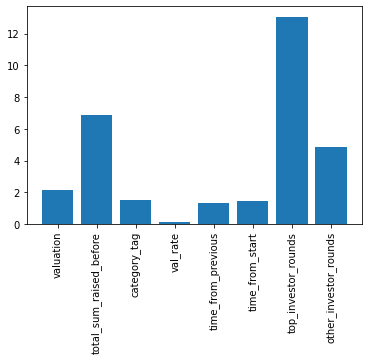

In [15]:
selector = SelectKBest(f_classif, k='all')
selector.fit(X_train_t, y_train)

#самый большой результат соответствует самому малому значению p-значения(вероятность ошибки)
#поэтому "переворачиваем", чтоб самые ценные признаки на графике были максимальными
scores = -np.log10(selector.pvalues_)

plt.bar(range(len(features)), scores)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [16]:
wave1_acc = []
wave1_PR = []
wave1_RC = []
wave1_features = []

### Sklearn Random Forest

In [17]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [None, 25, 50, 75, 100],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
}

estimator = RandomForestClassifier()
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2, scoring='accuracy')
grid_search.fit(X_train_t, y_train)
grid_search.best_params_

Fitting 5 folds for each of 990 candidates, totalling 4950 fits


{'bootstrap': True,
 'max_depth': 100,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 30}

In [18]:
acc_array = []
f1_array = []
PR_array = []
RC_array = []
feature_array = []
best_grid1 = grid_search.best_estimator_
for j in range(10):
    best_grid1.fit(X_train_t, y_train)
    predicted_labels = best_grid1.predict(X_test_t)
    acc = accuracy_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels, average = 'macro')
    PR = precision_score(y_test, predicted_labels, average = 'macro')
    RC = recall_score(y_test, predicted_labels, average = 'macro')
    acc_array.append(acc)
    PR_array.append(PR)
    RC_array.append(RC)
    f1_array.append(f1)
    feature_array.append(best_grid1.feature_importances_)
print(f'acc = {np.mean(acc_array)}')
print(f'PR = {np.mean(PR_array)}')
print(f'RC = {np.mean(RC_array)}')
print(f'f1 = {np.mean(f1_array)}')

acc = 0.6438775510204082
PR = 0.6372954091265128
RC = 0.6322410147991543
f1 = 0.6327676979880277


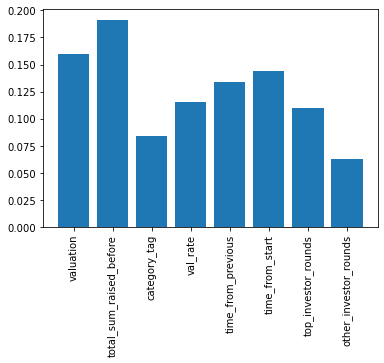

In [19]:
plt.bar(range(len(features)), best_grid1.feature_importances_)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [20]:
wave1_acc.append(np.mean(acc_array))
wave1_PR.append(np.mean(PR_array))
wave1_RC.append(np.mean(RC_array))
wave1_features.append(np.average(feature_array, axis=0))

### Sklearn Gradient Boosting

In [21]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [None, 25, 50, 75, 100],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [20, 50, 60, 70, 80, 90, 100, 110]
}

estimator = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2, scoring='accuracy')
grid_search.fit(X_train_t, y_train)
grid_search.best_params_

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


{'learning_rate': 0.3,
 'max_depth': 50,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 90}

In [22]:
acc_array = []
f1_array = []
PR_array = []
RC_array = []
feature_array = []
best_grid2 = grid_search.best_estimator_
for j in range(10):
    best_grid2.fit(X_train_t, y_train)
    predicted_labels = best_grid2.predict(X_test_t)
    acc = accuracy_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels, average = 'macro')
    PR = precision_score(y_test, predicted_labels, average = 'macro')
    RC = recall_score(y_test, predicted_labels, average = 'macro')
    acc_array.append(acc)
    PR_array.append(PR)
    RC_array.append(RC)
    f1_array.append(f1)
    feature_array.append(best_grid2.feature_importances_)
print(f'acc = {np.mean(acc_array)}')
print(f'PR = {np.mean(PR_array)}')
print(f'RC = {np.mean(RC_array)}')
print(f'f1 = {np.mean(f1_array)}')

acc = 0.6357142857142858
PR = 0.6286153397392644
RC = 0.6242071881606766
f1 = 0.624650833492338


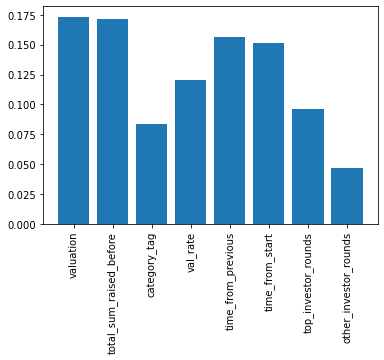

In [23]:
plt.bar(range(len(features)), best_grid2.feature_importances_)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [24]:
wave1_acc.append(np.mean(acc_array))
wave1_PR.append(np.mean(PR_array))
wave1_RC.append(np.mean(RC_array))
wave1_features.append(np.average(feature_array, axis=0))

### XGBoost

In [25]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

estimator = XGBClassifier(objective="binary:logistic")
grid_search = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3, scoring="accuracy") #verbose = 2, scoring='accuracy' roc_auc
grid_search.fit(X_train_t, y_train)
grid_search.best_params_

[02:17:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Barca\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'colsample_bytree': 0.5,
 'gamma': 1,
 'learning_rate': 0.05,
 'max_depth': 3,
 'reg_lambda': 10,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [26]:
grid_search.best_score_

0.6606248157972296

In [27]:
# best_grid3 = grid_search.best_estimator_
best_grid3 = XGBClassifier(objective="binary:logistic", **grid_search.best_params_)
best_grid3.fit(X_train_t, y_train)

[02:17:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
predicted_labels = best_grid3.predict(X_test_t)

roc_auc = roc_auc_score(y_test, predicted_labels)
acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average = 'macro')
PR = precision_score(y_test, predicted_labels, average = 'macro')
RC = recall_score(y_test, predicted_labels, average = 'macro')

print(f'acc = {acc}')
print(f'PR = {PR}')
print(f'RC = {RC}')
print(f'f1 = {f1}')

acc = 0.6632653061224489
PR = 0.6594669117647058
RC = 0.646723044397463
f1 = 0.6470588235294118


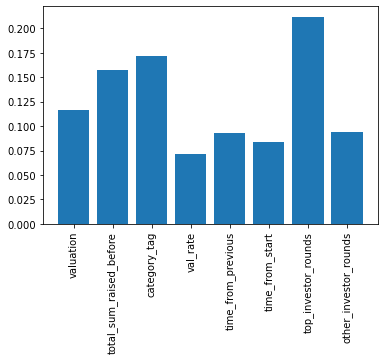

In [29]:
plt.bar(range(len(features)), best_grid3.feature_importances_)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [30]:
wave1_acc.append(acc)
wave1_PR.append(PR)
wave1_RC.append(RC)
wave1_features.append(best_grid3.feature_importances_)

In [31]:
wave1_acc

[0.6438775510204082, 0.6357142857142858, 0.6632653061224489]

In [32]:
wave1_PR

[0.6372954091265128, 0.6286153397392644, 0.6594669117647058]

In [33]:
wave1_RC

[0.6322410147991543, 0.6242071881606766, 0.646723044397463]

In [34]:
wave1_features

[array([0.15825734, 0.18765232, 0.09583725, 0.11810748, 0.13269587,
        0.1311541 , 0.11484285, 0.0614528 ]),
 array([0.17433654, 0.18069103, 0.08013433, 0.11982034, 0.15268282,
        0.14828925, 0.09464119, 0.04940452]),
 array([0.11648607, 0.15700737, 0.17207417, 0.07204539, 0.09280497,
        0.0834938 , 0.2118995 , 0.09418874], dtype=float32)]

In [35]:
wave1real_df = pd.DataFrame(list(zip([wave1_acc[0]], [wave1_acc[1]], [wave1_acc[2]])), 
               columns =['Random Forest', 'Gradient Boosting', 'XGBoost Classifier'])
wave1realf_df = pd.DataFrame(list(zip(wave1_features[0], wave1_features[1], wave1_features[2])), 
               columns =['Random Forest', 'Gradient Boosting', 'XGBoost Classifier'])
features = features.insert(0, 'ACCURACY')
parameters = pd.DataFrame(list(features), columns =['Parameter'])
wave1real_df = wave1real_df.append(wave1realf_df).reset_index(drop=True)
wave1real_df = pd.concat([parameters, wave1real_df], axis=1)
wave1real_df.to_csv('wave2real_results.csv', encoding = 'utf-8-sig')
wave1real_df

,Parameter,Random Forest,Gradient Boosting,XGBoost Classifier
0,ACCURACY,0.643878,0.635714,0.663265
1,valuation,0.158257,0.174337,0.116486
2,total_sum_raised_before,0.187652,0.180691,0.157007
3,category_tag,0.095837,0.080134,0.172074
4,val_rate,0.118107,0.119820,0.072045
5,time_from_previous,0.132696,0.152683,0.092805
6,time_from_start,0.131154,0.148289,0.083494
7,top_investor_rounds,0.114843,0.094641,0.211900
8,other_investor_rounds,0.061453,0.049405,0.094189


In [56]:
predicted_labels1 = best_grid1.predict(X_DEMO_t)
predicted_labels2 = best_grid2.predict(X_DEMO_t)
predicted_labels3 = best_grid3.predict(X_DEMO_t)

In [57]:
a = pd.DataFrame(list(predicted_labels1), columns =['Random_Forest'])
b = pd.DataFrame(list(predicted_labels2), columns =['Gradient_Boosting'])
c = pd.DataFrame(list(predicted_labels3), columns =['XGBoost_Classifier'])
demo = pd.concat([DEMO_SET[['company_name']].reset_index(drop=True), a, b, c], axis=1)
#demo.to_csv('forecast_w2r.csv', encoding = 'utf-8-sig')
demo

,company_name,Random_Forest,Gradient_Boosting,XGBoost_Classifier
0,Roblox Corporation,0.0,1.0,1.0
1,Lemonade,1.0,1.0,1.0
2,Palantir Technologies,1.0,1.0,1.0
3,DoorDash,1.0,1.0,1.0
4,JFrog,0.0,0.0,0.0
5,Unity Technologies,1.0,1.0,1.0
6,Sumo Logic,1.0,1.0,1.0
7,Snowflake Computing,1.0,1.0,1.0
8,Airbnb,1.0,1.0,1.0
9,Asana,1.0,1.0,1.0


In [58]:
predicted_labels1 = best_grid1.predict(X_DEMO2_t)
predicted_labels2 = best_grid2.predict(X_DEMO2_t)
predicted_labels3 = best_grid3.predict(X_DEMO2_t)

In [59]:
a = pd.DataFrame(list(predicted_labels1), columns =['Random_Forest'])
b = pd.DataFrame(list(predicted_labels2), columns =['Gradient_Boosting'])
c = pd.DataFrame(list(predicted_labels3), columns =['XGBoost_Classifier'])
demo = pd.concat([DEMO_SET2[['company_name']].reset_index(drop=True), a, b, c], axis=1)
#demo.to_csv('forecast_w2r_2.csv', encoding = 'utf-8-sig')
demo

,company_name,Random_Forest,Gradient_Boosting,XGBoost_Classifier
0,VertiFlex,1.0,0.0,1.0
1,mitú,1.0,1.0,1.0
2,Postmates,1.0,1.0,1.0
3,Calient Technologies,1.0,0.0,1.0
4,Kyriba Corporation,1.0,0.0,1.0
5,Vidyo,1.0,1.0,1.0
6,littleBits Electronics,0.0,0.0,0.0
7,Harry's,1.0,1.0,1.0
8,Numerify,1.0,1.0,1.0
9,Whistle Sports,0.0,0.0,0.0


In [60]:
predicted_labels1 = best_grid1.predict(X_DEMO_ALL_t)
predicted_labels2 = best_grid2.predict(X_DEMO_ALL_t)
predicted_labels3 = best_grid3.predict(X_DEMO_ALL_t)

In [61]:
a = pd.DataFrame(list(predicted_labels1), columns =['Random_Forest'])
b = pd.DataFrame(list(predicted_labels2), columns =['Gradient_Boosting'])
c = pd.DataFrame(list(predicted_labels3), columns =['XGBoost_Classifier'])
demo = pd.concat([DEMO_SET_ALL[['company_name']].reset_index(drop=True), a, b, c], axis=1)
demo.to_csv('forecast_w2r_all.csv', encoding = 'utf-8-sig')
demo

,company_name,Random_Forest,Gradient_Boosting,XGBoost_Classifier
0,BioAtla LLC,0.0,0.0,0.0
1,Lot18,0.0,0.0,0.0
2,Xcovery,0.0,0.0,0.0
3,HeartFlow,1.0,1.0,1.0
4,Udacity,1.0,1.0,1.0
...,...,...,...,...
2382,PowerVision,0.0,0.0,1.0
2383,Sisense,1.0,1.0,1.0
2384,IlluminOss Medical,0.0,1.0,1.0
2385,Checkr,1.0,1.0,1.0


### На единичных признаках

In [34]:
y = dataset[['not_dead']]
y = y.values.ravel()
X_general = dataset.drop(columns=['DateLong', 'Deflator', 'class', 'not_dead', 'exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'interpolated_money_valuation_usd', 'total_sum_raised', 'lnP', 'log_delta', 'top_investor', 'other_investor'])

skaler = StandardScaler()
param_grid = {
    'bootstrap': [True, False], #rf only
#    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], #boosting only
    'max_depth': [None, 25, 50, 75, 100],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
}
estimator = RandomForestClassifier() #0.65-0.71
#estimator = GradientBoostingClassifier() #0.6-0.66
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2, scoring='accuracy')

X_general.columns

Index(['time_from_2009', 'time_from_start', 'time_from_previous',
       'top_investor_count', 'other_investor_count', 'top_investor_sum',
       'other_investor_sum', 'top_investor_rounds', 'other_investor_rounds',
       'total_sum_raised_before', 'valuation', 'log_rate'],
      dtype='object')

In [35]:
mean_acc = []
mean_f1 = []
features = ['time_from_2009', 'time_from_start', 'time_from_previous',
       'top_investor_count', 'other_investor_count', 'top_investor_sum',
       'other_investor_sum', 'top_investor_rounds', 'other_investor_rounds',
       'total_sum_raised_before', 'valuation', 'val_rate']
for i in features:
    X = X_general[[i]]
    X = X.values.astype(np.float)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train_t = skaler.fit_transform(X_train)
    X_test_t = skaler.transform(X_test)
    grid_search.fit(X_train_t, y_train)
    best_grid = grid_search.best_estimator_
    
    acc_array = []
    f1_array = []
    PR_array = []
    RC_array = []
    for j in range(10):
        best_grid.fit(X_train_t, y_train)
        predicted_labels = best_grid.predict(X_test_t)
        acc = accuracy_score(y_test, predicted_labels)
        f1 = f1_score(y_test, predicted_labels, average = 'macro')
        PR = precision_score(y_test, predicted_labels, average = 'macro')
        RC = recall_score(y_test, predicted_labels, average = 'macro')
        acc_array.append(acc)
        PR_array.append(PR)
        RC_array.append(RC)
        f1_array.append(f1)
    mean_acc.append(np.mean(acc_array))
    mean_f1.append(np.mean(f1_array))
    #print(f'acc on {i} = {np.mean(acc_array)}')
    #print(f'f1 on {i} = {np.mean(f1_array)}')
mean_acc_f1_df = pd.DataFrame(list(zip(mean_acc, mean_f1)), 
               columns =['Accuracy', 'F-Score']).set_index([features])
print(mean_acc_f1_df)

Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   45.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   48.7s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   47.4s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   35.0s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   35.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   36.0s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   35.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   35.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   34.9s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   46.8s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   46.1s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   53.0s finished


                         Accuracy   F-Score
time_from_2009           0.565306  0.563126
time_from_start          0.478061  0.467657
time_from_previous       0.529082  0.526459
top_investor_count       0.601531  0.595516
other_investor_count     0.576020  0.518943
top_investor_sum         0.607143  0.603013
other_investor_sum       0.520918  0.439029
top_investor_rounds      0.621429  0.581416
other_investor_rounds    0.454082  0.395532
total_sum_raised_before  0.599490  0.559616
valuation                0.588776  0.577450
log_rate                 0.477041  0.466655


In [36]:
mean_acc_f1_df

,Accuracy,F-Score
time_from_2009,0.565306,0.563126
time_from_start,0.478061,0.467657
time_from_previous,0.529082,0.526459
top_investor_count,0.601531,0.595516
other_investor_count,0.576020,0.518943
top_investor_sum,0.607143,0.603013
other_investor_sum,0.520918,0.439029
top_investor_rounds,0.621429,0.581416
other_investor_rounds,0.454082,0.395532
total_sum_raised_before,0.599490,0.559616


In [76]:
# acc_train = []
# acc_test = []
# f1_train = []
# f1_test = []
# for i in range(1, 101):
#     #classifier = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=100, C=0.12, penalty='l1', n_jobs=-1) #меньше 0.6
#     #classifier = KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs =-1) #отвратительное качество
#     classifier = DecisionTreeClassifier(max_depth=100) #качество на уровне 0.65-0.7
    
#     #ensemble_classifier = BaggingClassifier(base_estimator=classifier, n_estimators=i, bootstrap=True, n_jobs=-1)
#     ensemble_classifier = RandomForestClassifier(n_estimators=i, n_jobs=-1) #качество на уровне 0.65-0.7
#     #ensemble_classifier = GradientBoostingClassifier(n_estimators=i, learning_rate=0.2, max_depth=10) #качество на уровне 0.6-0.7
    
#     ensemble_classifier.fit(X_train_t, y_train)
#     class_names = ensemble_classifier.classes_
#     y_train_b = label_binarize(y_train, class_names)
#     y_test_b = label_binarize(y_test, class_names)
#     y_predict_train_b = label_binarize(ensemble_classifier.predict(X_train_t), class_names)
#     y_predict_test_b = label_binarize(ensemble_classifier.predict(X_test_t), class_names)
#     acc_train.append(accuracy_score(y_train_b, y_predict_train_b))
#     f1_train.append(f1_score(y_train_b, y_predict_train_b, average='weighted'))
#     acc_test.append(accuracy_score(y_test_b, y_predict_test_b))
#     f1_test.append(f1_score(y_test_b, y_predict_test_b, average='weighted'))

# plt.figure(figsize=(7, 7))
# plt.plot(np.arange(1, 101), acc_train, label='accuracy train')
# plt.plot(np.arange(1, 101), f1_train, label='f1_score train')
# plt.plot(np.arange(1, 101), acc_test, label='accuracy test')
# plt.plot(np.arange(1, 101), f1_test, label='f1_score test')
# plt.xlabel('n_estimators')
# plt.ylabel('score')
# plt.legend()
# plt.grid()
# plt.show()

### LogReg, kNN, Decision Tree

In [17]:
#pg = {'C': np.linspace(0.01, 1, 10), 'penalty': ['l1', 'l2']}
#pg = {'n_neighbors': range(1, 21)}
#pg = {'max_depth': np.linspace(1, 100, 5)}

#classifier = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=1000, n_jobs =-1) #lbfgs
#classifier = KNeighborsClassifier(weights='distance')
#classifier = DecisionTreeClassifier()

#grid_search = GridSearchCV(estimator=classifier, n_jobs = -1, param_grid=pg, cv=5, scoring='accuracy')
#grid_search.fit(X_train_t, y_train)

#grid_search.best_params_

In [18]:
#best_classifier = grid_search.best_estimator_
#best_classifier.fit(X_train_t, y_train)

In [19]:
#predicted_labels = best_classifier.predict(X_test_t)

#acc = accuracy_score(y_test, predicted_labels)
#print(f'acc = {acc}')
#f1 = f1_score(y_test, predicted_labels, average = 'macro')
#print(f'f1 = {f1}')

In [20]:
#predict_proba = grid_search.predict_proba(X_test_t)
#for i in predict_proba:
#    print(i)

In [21]:
#class_names = grid_search.best_estimator_.classes_
#y_predict = grid_search.predict_proba(X_test_t)

##y_test_b = label_binarize(y_test, class_names)
#lb = LabelBinarizer()
#y_test_b = lb.fit_transform(y_test)
#y_test_b = np.hstack((1 - y_test_b, y_test_b))

#fpr = dict()
#tpr = dict()
#roc_auc = dict()
#for i in range(len(class_names)):
#    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_predict[:, i])
#    roc_auc[i] = auc(fpr[i], tpr[i])
    
##для микро
#fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_predict.ravel())
#roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

##макро
#all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
#mean_tpr = np.zeros_like(all_fpr)
#for i in range(len(class_names)):
#    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
#mean_tpr /= len(class_names)
#fpr['macro'] = all_fpr
#tpr['macro'] = mean_tpr
#roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

##графики
#plt.figure(figsize=(6,6))
#plt.plot(fpr['micro'], tpr['micro'], label='micro, auc = %.3f'%(roc_auc['micro']), linestyle='--')
#plt.plot(fpr['macro'], tpr['macro'], label='macro, auc = %.3f'%(roc_auc['macro']), linestyle='--')
#for i in range(len(class_names)):
#    plt.plot(fpr[i], tpr[i], label='class = %s, auc = %.3f'%(class_names[i], auc(fpr[i], tpr[i])))

#plt.title('ROC-Кривая')
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.legend()
#plt.show()

### Сокращение размерности

In [34]:
#pca = PCA()
#pca.fit(X_train_t)

#variance = np.cumsum(pca.explained_variance_ratio_)

#plt.figure(figsize=(5,5))
#plt.plot(variance)
#plt.xlabel('Components')
#plt.ylabel('EVR')
#plt.plot([0,46],[0.95,0.95])
#plt.show()

In [35]:
#pca = PCA(n_components=39)

#X_train_pca = pca.fit_transform(X_train_t)
#X_test_pca = pca.transform(X_test_t)

In [36]:
#pg = {'C': np.linspace(0.01, 1, 10), 'penalty': ['l1', 'l2']}
#pg = {'n_neighbors': range(1, 31)}
#pg = {'max_depth': np.linspace(1, 100, 5)}

In [37]:
#classifier = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=100, n_jobs =-1) #lbfgs
#classifier = KNeighborsClassifier(weights='distance')
#classifier = DecisionTreeClassifier()

#grid_search = GridSearchCV(estimator=classifier, n_jobs = -1, param_grid=pg, cv=5, scoring='accuracy')
#grid_search.fit(X_train_pca, y_train)

#grid_search.best_params_

In [38]:
#predicted_labels = grid_search.predict(X_test_pca)

#acc = accuracy_score(y_test, predicted_labels)
#f1 = f1_score(y_test, predicted_labels, average='weighted')
#print('acc = ', acc)
#print('f1 = ', f1)

### Catboost

In [63]:
y = dataset[['not_dead']] #'not_dead' 'exit_type' 'class'
X = dataset.drop(columns=['class', 'not_dead', 'exit_type', 'top_investor', 'other_investor', 'total_sum_raised', 'first_last_dif', 'stadia', 'investment_type', 'log_delta', 'price_usd', 'money_raised_usd', 'exp_months_std', 'funding_round_uuid', 'company_name', 'company_uuid', 'announced_on', 'exit_date', 'total_count', 'count_per_round', 'raised_amount_usd', 'post_money_valuation_usd', 'interpolated_money_valuation_usd', 'lnP'])

#только признаки команды (образование + опыт)
#X = X.drop(columns=['time_from_2009', 'time_from_previous', 'time_from_start', 'top_investor_sum', 'other_investor_sum', 'total_sum_raised_before', 'valuation', 'val_rate'])

#только инвестора и раунды
X = X[['valuation', 'val_rate', 'total_sum_raised_before', 'time_from_2009', 'time_from_previous', 'time_from_start', 'top_investor_sum', 'other_investor_sum']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

skaler = StandardScaler()
X_train_t = skaler.fit_transform(X_train)
X_eval_t = skaler.fit_transform(X_eval)
X_test_t = skaler.transform(X_test)

In [64]:
model = CatBoostClassifier(has_time=True, iterations=1000, depth=10, learning_rate=0.1, loss_function='CrossEntropy')
model.fit(X_train_t, y_train, eval_set=(X_eval_t, y_eval), verbose=100)

print ('CatBoost: prediction of %s: RMSLE on test = %s' % ('not_dead', model.evals_result_['validation']['CrossEntropy'][-1]))

0:	learn: 0.6514671	test: 0.6741755	best: 0.6741755 (0)	total: 155ms	remaining: 2m 34s
100:	learn: 0.0489779	test: 0.6215706	best: 0.5913487 (16)	total: 1.58s	remaining: 14.1s
200:	learn: 0.0177040	test: 0.6744059	best: 0.5913487 (16)	total: 2.9s	remaining: 11.6s
300:	learn: 0.0101371	test: 0.7124593	best: 0.5913487 (16)	total: 4.2s	remaining: 9.76s
400:	learn: 0.0069237	test: 0.7399347	best: 0.5913487 (16)	total: 5.55s	remaining: 8.29s
500:	learn: 0.0053840	test: 0.7578491	best: 0.5913487 (16)	total: 6.87s	remaining: 6.84s
600:	learn: 0.0044076	test: 0.7763442	best: 0.5913487 (16)	total: 8.21s	remaining: 5.45s
700:	learn: 0.0038291	test: 0.7896251	best: 0.5913487 (16)	total: 9.62s	remaining: 4.1s
800:	learn: 0.0033698	test: 0.7988073	best: 0.5913487 (16)	total: 10.9s	remaining: 2.72s
900:	learn: 0.0030590	test: 0.8067507	best: 0.5913487 (16)	total: 12.3s	remaining: 1.35s
999:	learn: 0.0028825	test: 0.8127623	best: 0.5913487 (16)	total: 13.7s	remaining: 0us

bestTest = 0.5913486676
bes

In [65]:
y_pred = model.predict(X_test_t)
y_pred

array([1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0],
      dtype=int64)

In [66]:
y_test = y_test.values.ravel()
y_test

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.])

In [67]:
print ('\nCatBoost: prediction of %s. Feature importance. Type=PredictionValuesChange' % 'log_delta')
print (model.get_feature_importance(type=cb.EFstrType.PredictionValuesChange, prettified=True).head(25).to_string())


CatBoost: prediction of log_delta. Feature importance. Type=PredictionValuesChange
  Feature Id  Importances
0          6    19.197516
1          3    18.696240
2          0    17.847655
3          7    12.064020
4          2     9.962412
5          4     8.120351
6          5     7.730078
7          1     6.381729


In [68]:
model.score(X_test_t, y_test)

0.6564885496183206